# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install optuna -q
%pip install eli5 -q
%pip install catboost -q
%pip install joblib -q
%pip install scipy -q
%pip install transformers -q
%pip install pytorch-lightning -q
%pip install torchmetrics -q
%pip install shap -q
%pip install mlxtend -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 10.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 r

In [ ]:
import os
import time

import optuna

import numpy as np

import json

from sklearn.metrics import classification_report

import IPython.display as ipd

%matplotlib inline
import matplotlib.pyplot as plt

import joblib
import sys

#sys.modules['sklearn.externals.joblib'] = joblib
import gc

import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay,make_scorer , f1_score, mean_squared_error, confusion_matrix, accuracy_score, auc, roc_auc_score, roc_curve, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from PIL import Image

import pathlib

import csv

import catboost as cb
from catboost import CatBoostError


import eli5
from eli5.sklearn import PermutationImportance

import pandas as pd

import seaborn as sns

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import *
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Загрузка и первичный анализ

In [ ]:
# reading the data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tests/parsed_reviews3.csv')

# getting the shape
print(data.shape)

data.head()

(92735, 5)


,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


Как мы можем заметить, пропуски и пустые значения у нас отсутсвуют, поэтому ничего заменять или удалять не нужно

In [ ]:
data.isnull().sum()

body         0
title        0
rating       0
bank_name    0
date         0
dtype: int64

In [ ]:
data.info(memory_usage="deep")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 154.2 MB


In [ ]:
# Подсчитаем кол-во уникальных значений в каждой колонке
for col in data:
    print(col, data[col].nunique())

# Можно заметить, что rating у rating у нас стоит 5 видов значений,
#  но мы их не будем категоризировать, так как мы будем потом работать с этими значениями

body 91832
title 54505
rating 5
bank_name 157
date 91059


Как можно заметить ниже - у нас присутствует дисбаланс в рейтинге

In [ ]:
# Подсчитаем кол-во оценок
data["rating"].value_counts()

5    67244
1    18433
4     3466
2     2410
3     1182
Name: rating, dtype: int64

In [ ]:
#Агора, ЖК «1-й Нагатинский», 
# Тут мы можем провести анализ по тому, какие банки у нас вообще есть (и банк ли это вообще)
a = data['bank_name'].value_counts()
print(a.to_string())


Тинькофф Банк                                 44864
Хоум Кредит Банк                               9310
Совкомбанк                                     6111
ВТБ                                            3817
СберБанк                                       3490
Альфа-Банк                                     3369
Россельхозбанк                                 3064
Банк Открытие                                  1894
МТС Банк                                       1542
Модульбанк                                     1460
Газпромбанк                                    1314
Московский Кредитный Банк                      1251
Азиатско-Тихоокеанский Банк                    1001
Уральский Банк Реконструкции и Развития         748
Русский Стандарт                                689
Ренессанс Кредит                                686
Почта Банк                                      648
Точка                                           624
Росбанк                                         556
Кредит Европ

In [ ]:
# удалить колонки, где имеются данные сверху 
data = data[data.bank_name != "Агора" ]
data = data[data.bank_name != "ЖК «1-й Нагатинский»" ]


data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92732 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92732 non-null  object
 1   title      92732 non-null  object
 2   rating     92732 non-null  int64 
 3   bank_name  92732 non-null  object
 4   date       92732 non-null  object
dtypes: int64(1), object(4)
memory usage: 262.8 MB


In [ ]:
# Так или иначе, можно категоризировать банки ! 
data["bank_name"] = data["bank_name"].astype("category")
data['date']= pd.to_datetime(data['date'])

# Добавим колонку с месяцем и неделями. Они нам помогут в обучении модели и в визуализации
data['month'] = data['date'].dt.month
data["month"] = data["month"].astype("category")

data['week'] = data['date'].apply(lambda d: (d.day-1) // 7 + 1)
data["week"] = data["week"].astype("category")

data['target'] = data['rating'].apply(lambda x: "Positive" if x in (3,4,5) else "Negative")
data["target"] = data["target"].astype("category")

data['Target'] = data['rating'].apply(lambda x: 1 if x in (3,4,5) else 0)
data["Target"] = data["Target"].astype("category")

data.info(memory_usage="deep") # Размер увеличился, но теперь банки будет проще категоризировать

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92732 entries, 0 to 92734
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   body       92732 non-null  object        
 1   title      92732 non-null  object        
 2   rating     92732 non-null  int64         
 3   bank_name  92732 non-null  category      
 4   date       92732 non-null  datetime64[ns]
 5   month      92732 non-null  category      
 6   week       92732 non-null  category      
 7   target     92732 non-null  category      
 8   Target     92732 non-null  category      
dtypes: category(5), datetime64[ns](1), int64(1), object(2)
memory usage: 245.6 MB


In [ ]:
data.nunique()

body         91829
title        54502
rating           5
bank_name      155
date         91056
month            5
week             5
target           2
Target           2
dtype: int64

In [ ]:
# Чистим текст от лишних символов:
data['body'] = data['body'].str.replace(r'&lt;', ' ')
data['body'] = data['body'].str.replace(r'p&gt;', '')
data['body'] = data['body'].str.replace(r'/\r\n', '')
data['body'] = data['body'].str.replace(r'&quot;', '"')
data['body'] = data['body'].str.replace(r'br&gt;', '')

data.head(20)
# Видно, что мы очистили датасет от ненужных символов. Теперь можем приступить к визуализации

,body,title,rating,bank_name,date,month,week,target,Target
0,Добрый день пишу сюда для более скорого разр...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,1,1,Negative,0
1,"При возврате просроченной задолженности, банк...",Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,1,1,Negative,0
2,"07.09.22 ю была оформлена кредитная карта ""12...","Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,1,1,Negative,0
3,Новый год начинается с приятностей) Никогда ...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,1,Positive,1
4,Увидела на сайте Газпромбанка акцию с бонусом...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,1,1,Negative,0
5,"Суперудобный банк, нет комиссии за перевод на...",Отличный банк для ИПшников,5,Точка,2023-01-03 12:08:35,1,1,Positive,1
6,Самый худший банк в стране!!! Сотрудники банк...,Мошенники,1,ВТБ,2023-01-03 12:04:02,1,1,Negative,0
7,"Добрый день. Взяли кредит осенью 2022, ни р...",Звонки!,1,Почта Банк,2023-01-03 11:59:04,1,1,Negative,0
8,Мне очень понравился тинькофф и как оформленн...,Хороший банк,5,Тинькофф Банк,2023-01-03 11:58:32,1,1,Positive,1
9,"В декабре уже было написано, что 512 баллов к...",Глюченный банк,1,Хоум Кредит Банк,2023-01-03 11:47:17,1,1,Negative,0


#какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?


Тут мы наблюдаем топ 15 банков по кол-во отзывов

In [ ]:
top_15_banks = data.groupby(['bank_name'])['body'].count().nlargest(15)
top_15_banks

bank_name
Тинькофф Банк                              44864
Хоум Кредит Банк                            9310
Совкомбанк                                  6111
ВТБ                                         3817
СберБанк                                    3490
Альфа-Банк                                  3369
Россельхозбанк                              3064
Банк Открытие                               1894
МТС Банк                                    1542
Модульбанк                                  1460
Газпромбанк                                 1314
Московский Кредитный Банк                   1251
Азиатско-Тихоокеанский Банк                 1001
Уральский Банк Реконструкции и Развития      748
Русский Стандарт                             689
Name: body, dtype: int64

Как мы видим, Тинькофф имеет самый высокий рейтинг среди всех топ-15 банков. На втором месте Модульбанк, а на третьем Азиатско-Тихоокеанский

In [ ]:
data.loc[data['bank_name'].isin(top_15_banks.index)].groupby(['bank_name'])['rating'].mean().nlargest(15)

bank_name
Тинькофф Банк                              4.783568
Модульбанк                                 4.780137
Азиатско-Тихоокеанский Банк                4.718282
Хоум Кредит Банк                           4.505585
Россельхозбанк                             4.455940
Совкомбанк                                 4.264768
Московский Кредитный Банк                  4.241407
Русский Стандарт                           4.158200
Банк Открытие                              3.543295
Уральский Банк Реконструкции и Развития    3.298128
МТС Банк                                   2.901427
СберБанк                                   2.303725
Газпромбанк                                2.145358
ВТБ                                        1.950223
Альфа-Банк                                 1.714159
Name: rating, dtype: float64

***Почему такие банки попали в данный рейтинг ?***

Моё предположение такое - после блокировки Visa и MasterCard в России - эти банки предоставляли новые карты с системой UnionPay. Именно поэтому они могли оказаться в данном топе и иметь высокие оценки.



---



#сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов


In [ ]:
top_5_banks = data.groupby(['bank_name'])['body'].count().nlargest(5)
top_5_banks

bank_name
Тинькофф Банк       44864
Хоум Кредит Банк     9310
Совкомбанк           6111
ВТБ                  3817
СберБанк             3490
Name: body, dtype: int64

In [ ]:
res_to_5_banks = (data.loc[data['bank_name'].isin(top_5_banks.index)].groupby([data.date.dt.year,data.date.dt.month, #
            'bank_name'])['rating']
  .mean()).dropna()
res_to_5_banks

date  date  bank_name       
2022  9     ВТБ                 2.073814
            СберБанк            1.920000
            Совкомбанк          3.883544
            Тинькофф Банк       3.888102
            Хоум Кредит Банк    4.060465
      10    ВТБ                 1.914620
            СберБанк            2.777547
            Совкомбанк          3.846561
            Тинькофф Банк       4.865877
            Хоум Кредит Банк    3.591479
      11    ВТБ                 1.993778
            СберБанк            2.562708
            Совкомбанк          4.230511
            Тинькофф Банк       4.841598
            Хоум Кредит Банк    4.001401
      12    ВТБ                 1.896052
            СберБанк            1.868263
            Совкомбанк          4.524676
            Тинькофф Банк       4.650189
            Хоум Кредит Банк    4.626306
2023  1     ВТБ                 1.148148
            СберБанк            1.400000
            Совкомбанк          4.419355
            Тинькофф Банк   

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5777951eb0>],
      dtype=object)

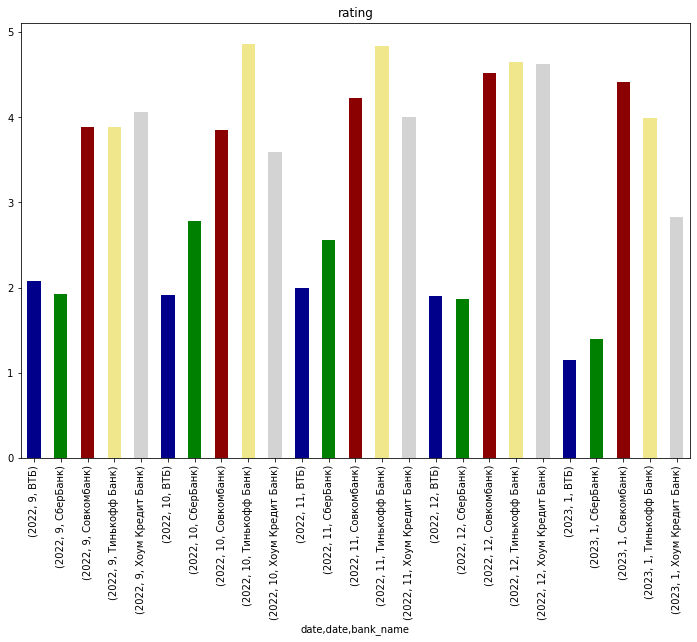

In [ ]:
colors = ['darkblue' if "ВТБ" in x
          else 'khaki' if "Тинькофф Банк" in x 
          else 'green' if "СберБанк" in x
          else 'darkred' if "Совкомбанк" in x 
          else 'lightgrey' for x in res_to_5_banks.index]

res_to_5_banks.plot(kind='bar', subplots=True, sharey=True, figsize=(12,8),color=colors, )

Глядя на график выше можно заметить, что средний рейтинг менялся таким образом у каждого банка:

Небольшое введение: *(Стоит заметить, что данные за январь 2023 года показаны не за весь месяц, а только за 1 половину месяца, поэтому падение наблюдается у всех, что делает анализ января немного необъективным, но его мы поп прежнему не будем убирать из выборки !)* 

---

Втб - его оценка держалась в районе 2 всё время до 2023 года. После 2023 его рейтинг упал примерно до 1, практически как у всех банков. Так или иначе, данный банк показывал стабильность в ноябре и декабре и на данный банк в то время можно было рассчитывать

Сбербанк - напоминает график экспоненциального распределения. Сначала он возрастает, а после идёт на снижение. Причем, когда у всех было падение в 2023 году, сбербанк тоже упал, но у него было одно из самых "мягких" падений. Данный банк тоже наблюдал рост до ноября, а после пошёл на снижение

Совкомбанк - имел довольно-таки стабильный рост до декабря и, пожалуй, имеет самое мягкое падение в 2023 году. Как мы видим - совкомбанк имеет реально самую стабильную аудиторию, которая часто ставит хорошие оценки. (но по поводу оценок мы поговорим позже)

Тинькофф банк - является несомненным лидером по рейтингу с октября по декабрь. Рост наверняка связан с ещё большим объемом рекламы и различных услуг, которые предоставляет банк. Так или иначе, данный банк потерял своё первенство в январе и судя по тенденции - продолжит дальше терять.

Хоум кредит банк - самый неоднозначный банк, который в определенный момент упал, а после повысил свой рейтинг до такого уровня, что тесно конкурировал с тинькофф банком. В январе данный банк больше всех потерял в плане рейтинга.

#**нет ли в данных в целом каких-то странностей на ваш взгляд?**

Очень часто люди не пишут о положительном опыте. Посмотрите на отзывы и вы заметите, что иногда положительные оценки существуют, но это происходит крайне редко и к этому стоит относиться со скепсисом. 

Давайте же тогда обратим внимание на оценку 5 и посмотрим на сколько же она объективна !

In [ ]:
temp = data["rating"].isin({5}) == True
temp

0        False
1        False
2        False
3         True
4        False
         ...  
92730    False
92731     True
92732    False
92733    False
92734     True
Name: rating, Length: 92732, dtype: bool

In [ ]:
temp=(temp.where(temp == True).dropna().index)
temp_len = len(temp)
temp=temp[int(temp_len/2):]
temp

Int64Index([47603, 47604, 47605, 47606, 47607, 47608, 47609, 47610, 47611,
            47612,
            ...
            92710, 92716, 92720, 92723, 92724, 92725, 92726, 92727, 92731,
            92734],
           dtype='int64', length=33622)

In [ ]:
len(temp)

33622

*Что я сделал ?*

Я удалил половину оценок, где есть оценка 5, чтобы постараться быть более объективным.

In [ ]:
data_analyze = data.copy()
data_analyze=data_analyze.drop(temp, axis=0)
data_analyze.head(5)

,body,title,rating,bank_name,date,month,week,target,Target
0,Добрый день пишу сюда для более скорого разр...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,1,1,Negative,0
1,"При возврате просроченной задолженности, банк...",Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,1,1,Negative,0
2,"07.09.22 ю была оформлена кредитная карта ""12...","Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,1,1,Negative,0
3,Новый год начинается с приятностей) Никогда ...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,1,1,Positive,1
4,Увидела на сайте Газпромбанка акцию с бонусом...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,1,1,Negative,0


Давайте теперь взглянем на среднюю оценку

In [ ]:
top_10_banks = data_analyze.groupby(['bank_name'])['body'].count().nlargest(10)
top_10_banks

bank_name
Тинькофф Банк       19682
Хоум Кредит Банк     8718
Совкомбанк           4807
ВТБ                  3513
Альфа-Банк           3240
СберБанк             2898
Россельхозбанк       2063
Банк Открытие        1435
МТС Банк             1179
Газпромбанк          1175
Name: body, dtype: int64

In [ ]:
data_analyze.loc[data_analyze['bank_name'].isin(top_10_banks.index)].groupby(['bank_name'])['rating'].mean().nlargest(10)

bank_name
Тинькофф Банк       4.506656
Хоум Кредит Банк    4.472012
Россельхозбанк      4.191953
Совкомбанк          4.065321
Банк Открытие       3.077352
МТС Банк            2.255301
Газпромбанк         1.807660
СберБанк            1.752933
ВТБ                 1.686308
Альфа-Банк          1.583333
Name: rating, dtype: float64

Исходя из тех данных, представленных выше, можно сказать, что скорее-всего рейтинг где-то точно "накручивали". 

Это нормальное явление и с ним ничего нельзя сделать. Заметим, что теперь позиции совершенно иные и на 3 месте у нас стоит россельхоз банк, а такие банки, как тихоокеанский и Модуль банк вовсе исчезли

Субъективно - надо всегда убирать оценку 5 из списка и смотреть, что и как, так как очень часто данная оценка не является действительной

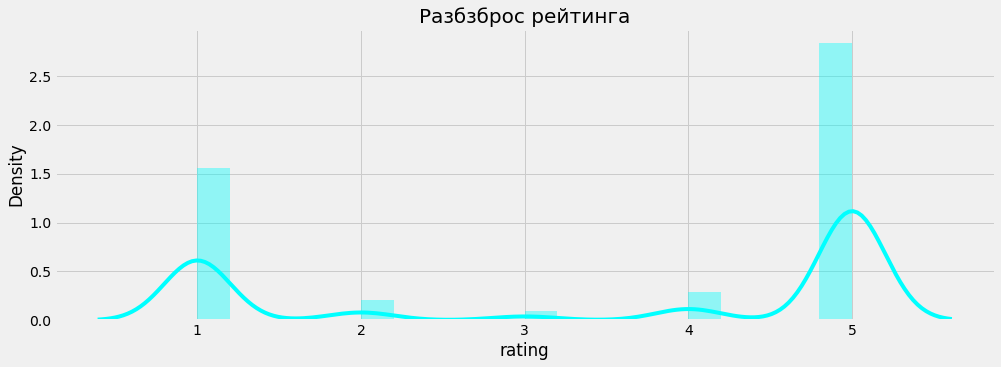

In [ ]:
# Как мы теперь видим, разброс стал чуть меньше, но оценка 5 так всё ещё стоит
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(data_analyze['rating'], color = 'cyan')
plt.title('Разбзброс рейтинга', fontsize = 20)
plt.show()


---
Давайте уберем оценку 5 ? 

In [ ]:
temp = data["rating"].isin({5}) == True
temp

0        False
1        False
2        False
3         True
4        False
         ...  
92730    False
92731     True
92732    False
92733    False
92734     True
Name: rating, Length: 92732, dtype: bool

In [ ]:
temp=(temp.where(temp == True).dropna().index)
temp

Int64Index([    3,     5,     8,    10,    12,    15,    16,    17,    18,
               22,
            ...
            92710, 92716, 92720, 92723, 92724, 92725, 92726, 92727, 92731,
            92734],
           dtype='int64', length=67243)

In [ ]:
data_analyze = data.copy()
data_analyze=data_analyze.drop(temp, axis=0)
print(len(data_analyze))
data_analyze.head(5)

25489


,body,title,rating,bank_name,date,month,week,target,Target
0,Добрый день пишу сюда для более скорого разр...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,1,1,Negative,0
1,"При возврате просроченной задолженности, банк...",Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,1,1,Negative,0
2,"07.09.22 ю была оформлена кредитная карта ""12...","Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,1,1,Negative,0
4,Увидела на сайте Газпромбанка акцию с бонусом...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,1,1,Negative,0
6,Самый худший банк в стране!!! Сотрудники банк...,Мошенники,1,ВТБ,2023-01-03 12:04:02,1,1,Negative,0


Давайте теперь взглянем на среднюю оценку

In [ ]:
top_10_banks = data_analyze.groupby(['bank_name'])['body'].count().nlargest(10)
top_10_banks

bank_name
Тинькофф Банк       3387
ВТБ                 3107
Альфа-Банк          2903
СберБанк            2499
Хоум Кредит Банк    2478
Совкомбанк          1359
Газпромбанк         1003
МТС Банк             865
Банк Открытие        807
Ренессанс Кредит     628
Name: body, dtype: int64

In [ ]:
data_analyze.loc[data_analyze['bank_name'].isin(top_10_banks.index)].groupby(['bank_name'])['rating'].mean().nlargest(10)

bank_name
Хоум Кредит Банк    3.142454
Тинькофф Банк       2.133156
Совкомбанк          1.693893
Банк Открытие       1.581165
Ренессанс Кредит    1.288217
Газпромбанк         1.260219
МТС Банк            1.258960
ВТБ                 1.253299
СберБанк            1.234494
Альфа-Банк          1.186703
Name: rating, dtype: float64

Интересно ! 

Теперь Хоум Кредит Банк занимает лидирующую позицию в рейтинге, тогда же как тинькофф стоит на 2 месте 

Давайте посмотрим на изменение их рейтинга на протяжении всех месяцев !

In [ ]:
top_5_banks = data_analyze.groupby(['bank_name'])['body'].count().nlargest(5)
top_5_banks

bank_name
Тинькофф Банк       3387
ВТБ                 3107
Альфа-Банк          2903
СберБанк            2499
Хоум Кредит Банк    2478
Name: body, dtype: int64

In [ ]:
res_to_5_banks = (data_analyze.loc[data_analyze['bank_name'].isin(top_5_banks.index)].groupby([data_analyze.date.dt.year,data_analyze.date.dt.month, #
            'bank_name'])['rating']
  .mean()).dropna()
res_to_5_banks

date  date  bank_name       
2022  9     Альфа-Банк          1.143098
            ВТБ                 1.233032
            СберБанк            1.158004
            Тинькофф Банк       1.288416
            Хоум Кредит Банк    2.051095
      10    Альфа-Банк          1.193426
            ВТБ                 1.252841
            СберБанк            1.249123
            Тинькофф Банк       2.460594
            Хоум Кредит Банк    1.945652
      11    Альфа-Банк          1.177907
            ВТБ                 1.238042
            СберБанк            1.290541
            Тинькофф Банк       2.418489
            Хоум Кредит Банк    2.125000
      12    Альфа-Банк          1.232964
            ВТБ                 1.278261
            СберБанк            1.223827
            Тинькофф Банк       1.896118
            Хоум Кредит Банк    3.476341
2023  1     Альфа-Банк          1.148148
            ВТБ                 1.148148
            СберБанк            1.400000
            Тинькофф Банк   

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5770267640>],
      dtype=object)

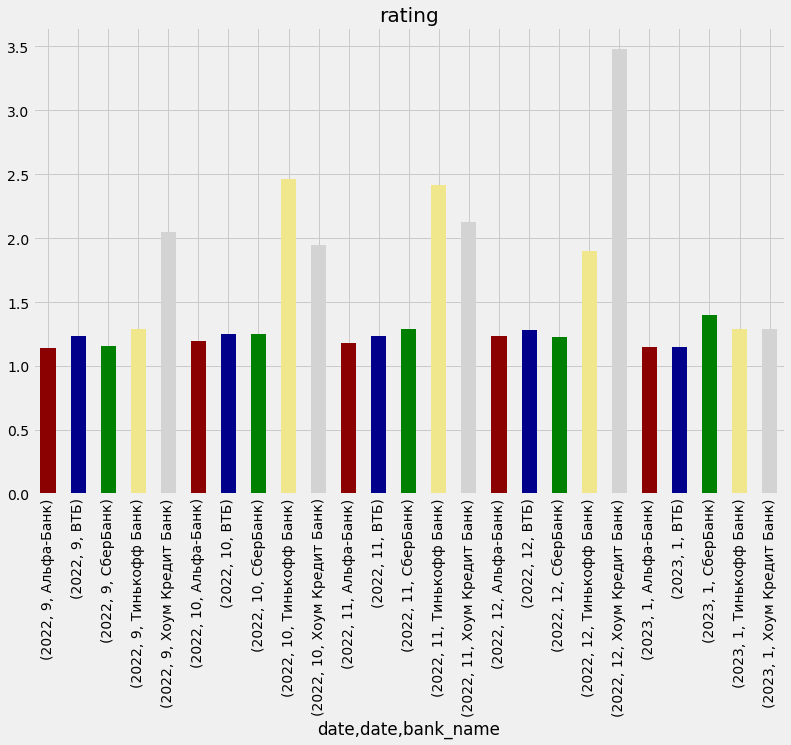

In [ ]:
colors = ['darkblue' if "ВТБ" in x
          else 'khaki' if "Тинькофф Банк" in x 
          else 'green' if "СберБанк" in x
          else 'darkred' if "Альфа-Банк" in x 
          else 'lightgrey' for x in res_to_5_banks.index]

res_to_5_banks.plot(kind='bar', subplots=True, sharey=True, figsize=(12,8),color=colors, )

Как мы видим, Хоум кредит банк и Тинькофф остаются в своеобразном топе, даже когда у них нет оценок 5

**дополнительный EDA на ваше усмотрение, возможные интересные наблюдения**

# Визуализация

In [ ]:
df['result'].value_counts().plot(kind='pie', autopct='%1.1f%%',)

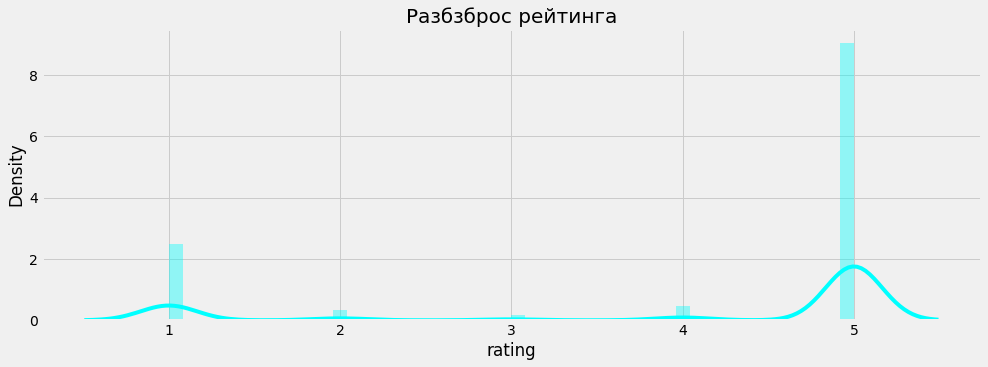

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 5)
sns.distplot(data['rating'], color = 'cyan')
plt.title('Разбзброс рейтинга', fontsize = 20)
plt.show()

In [ ]:
corr_meat = data.corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix
fig = sns.clustermap(corr_meat,
               row_cluster=True,
               col_cluster=True,
               figsize=(10, 10));

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

In [ ]:
 ax = sns.countplot(x="rating", data=data,hue="month",palette="Set1")

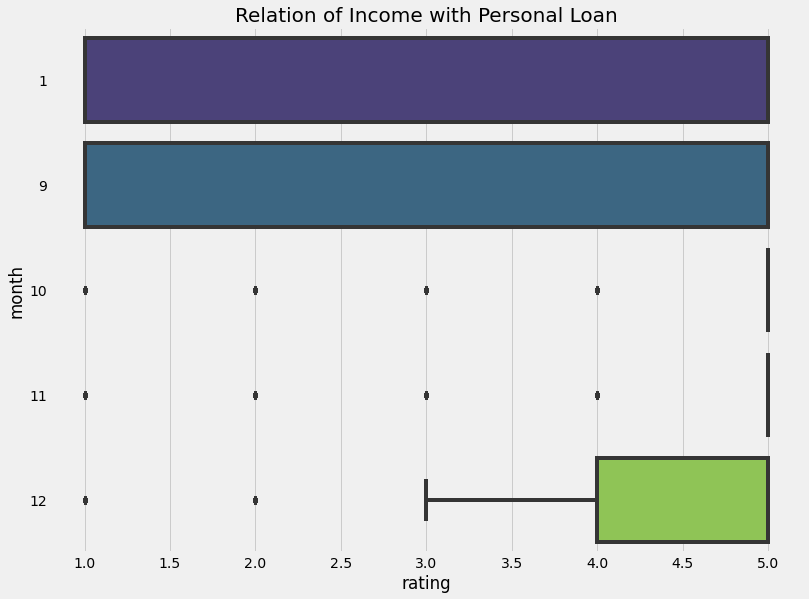

In [ ]:
# show relation of income with personal loan

plt.rcParams['figure.figsize'] = (12, 9)
sns.boxplot(data['rating'], data['month'], palette = 'viridis')
plt.title('Relation of Income with Personal Loan', fontsize = 20)
plt.show()

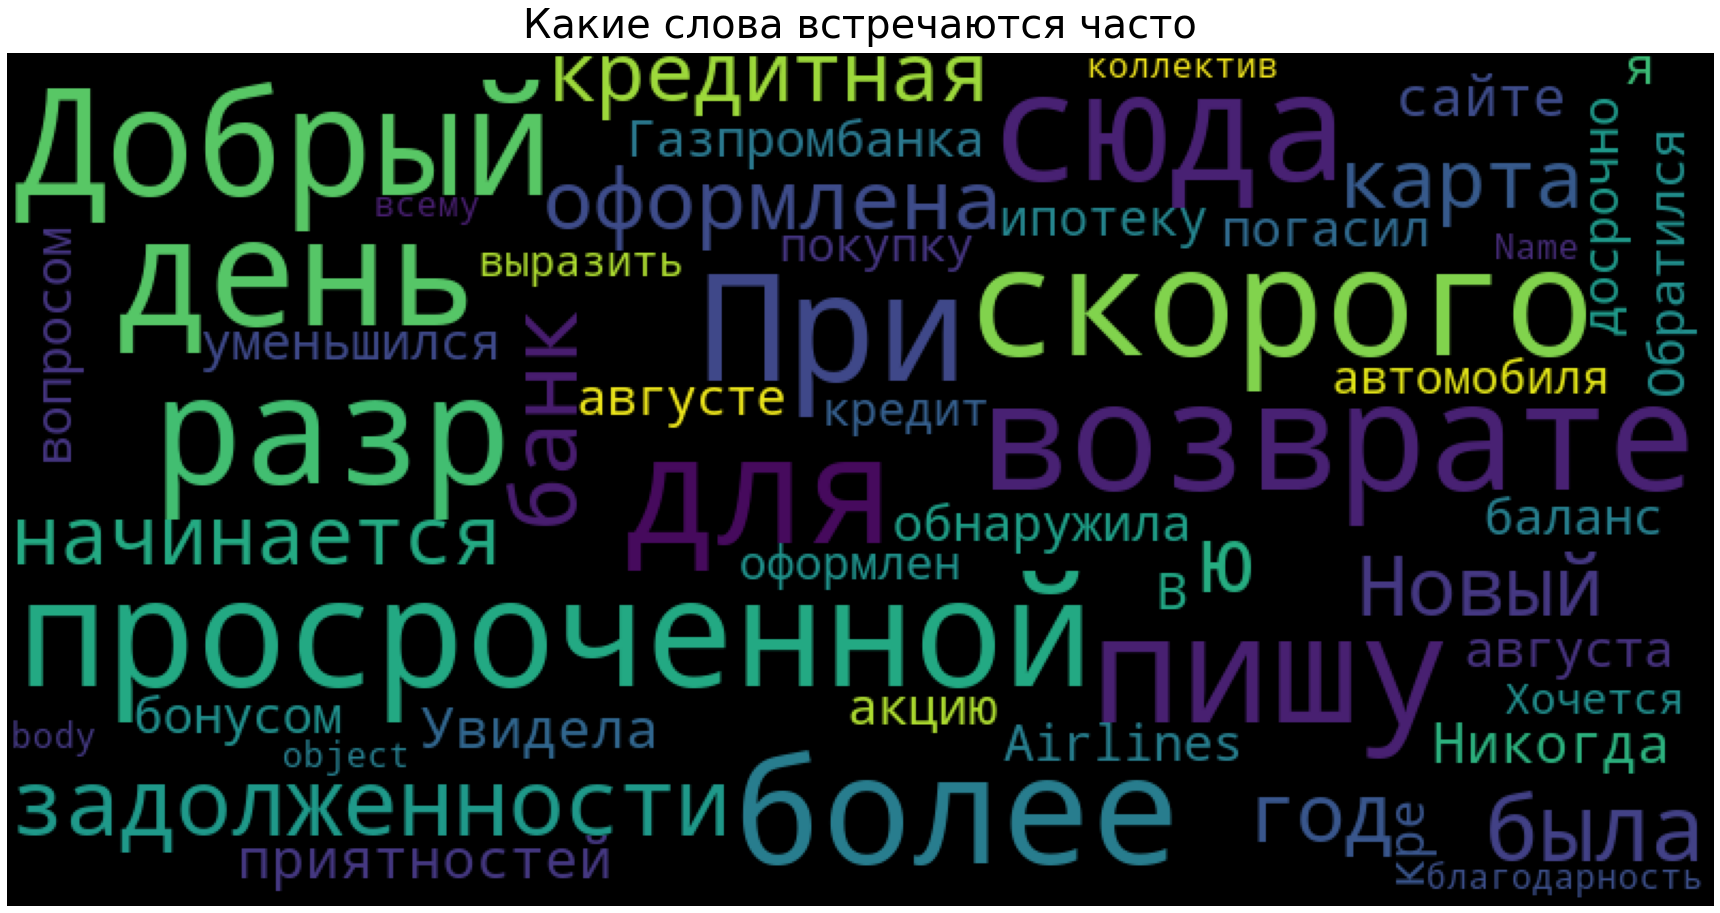

In [ ]:
%%time

import spacy # I'll be making use of spacy for text preprocessing
from spacy.lang.ru.stop_words import STOP_WORDS
from spacy.lang.ru import Russian
import string, re
# from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.lang.en import English, Russian



from wordcloud import WordCloud, STOPWORDS
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=70, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'С', 'на', 'по', 'что', 'dtype', 'Length', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(data["body"], title="Какие слова встречаются часто")

In [ ]:
%%time

from collections import defaultdict
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py

freq_dict = defaultdict(int)
for sent in data["body"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), '#ff414e')


# freq_dict = defaultdict(int)
# for sent in data["body"]:
#     for word in generate_ngrams(sent,2):
#         freq_dict[word] += 1
# fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
# fd_sorted.columns = ["word", "wordcount"]
# trace1 = horizontal_bar_chart(fd_sorted.head(50), '#12343b')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions"])
fig.append_trace(trace0, 1, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='#f7f7f7', title="Частота различных слов")
py.iplot(fig, filename='word-plots')

# NLP

Positive    71890
Negative    20842
Name: target, dtype: int64


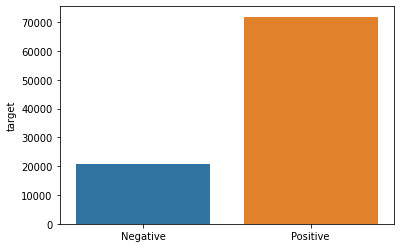

In [ ]:
x=data['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [ ]:
#1. WORD-COUNT
data['word_count'] = data['body'].apply(lambda x: len(str(x).split()))
print(data[data['target']=="Positive"]['word_count'].mean()) #Disaster tweets
print(data[data['target']=="Negative"]['word_count'].mean()) #Non-Disaster tweets
#Disaster tweets are more wordy than the non-disaster tweets

#2. CHARACTER-COUNT
data['char_count'] = data['body'].apply(lambda x: len(str(x)))
print(data[data['target']=="Positive"]['char_count'].mean()) #Disaster tweets
print(data[data['target']=="Negative"]['char_count'].mean()) #Non-Disaster tweets
#Disaster tweets are longer than the non-disaster tweets

#3. UNIQUE WORD-COUNT
data['unique_word_count'] = data['body'].apply(lambda x: len(set(str(x).split())))
print(data[data['target']=="Positive"]['unique_word_count'].mean()) #Disaster tweets
print(data[data['target']=="Negative"]['unique_word_count'].mean()) #Non-Disaster tweets

71.12533036583669
164.78941560310912
482.42852969814993
1080.5107475290279
61.73630546668522
125.54121485462048


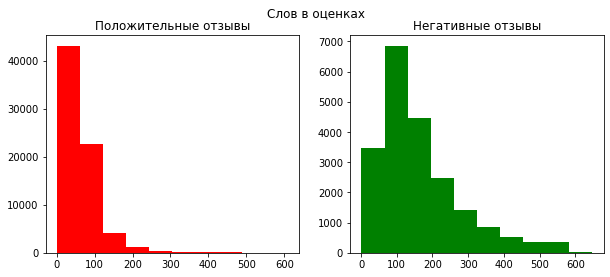

In [ ]:
#Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=data[data['target']=="Positive"]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Положительные отзывы')
train_words=data[data['target']=="Negative"]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Негативные отзывы')
fig.suptitle('Слов в оценках')
plt.show()

In [ ]:
#1. Common text preprocessing
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess(text)
print(text)  #text is a string

this is a message to be cleaned it may involve some things like adjacent spaces and tabs


In [ ]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('russian')]
    return ' '.join(a)

text=stopword(text)
print(text)

#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('russian')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

this is a message to be cleaned it may involve some things like adjacent spaces and tabs
this is a message to be cleaned it may involve some things like adjacent spaces and tabs
this be a message to be clean it may involve some thing like adjacent space and tab


In [ ]:
#FINAL PREPROCESSING
%%time
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

data['clean_text'] = data['body'].apply(lambda x: finalpreprocess(x))
data['clean_title'] = data['title'].apply(lambda x: finalpreprocess(x))


df_train=data.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

In [ ]:
%%time
#gc.collect()
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it

In [ ]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

In [ ]:
#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X=df_train["clean_text"]
y=df_train["Target"]
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  #df_train.drop(columns=['Target'], axis=1),
                                                  y,
                                                  test_size=0.3,
                                                  shuffle=True,
                                                  stratify=df_train['Target'])
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

gc.collect()


In [ ]:
X_tok= [nltk.word_tokenize(i) for i in X]  #for word2vec

In [ ]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_vectors_tfidf = tfidf_vectorizer.fit_transform(X)

In [ ]:
modelw = MeanEmbeddingVectorizer(w2v)
X_vectors_w2v = modelw.transform(X_tok)

In [ ]:
X_vectors_w2v.shape,X_vectors_tfidf, y.shape

In [ ]:

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)

In [ ]:
#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible

In [ ]:
#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [ ]:
y_train.shape

In [ ]:
X_train_vectors_tfidf.shape

In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

log_reg=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
log_reg.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict_val = log_reg.predict(X_val_vectors_tfidf)
y_prob_val = log_reg.predict_proba(X_val_vectors_tfidf)[:,1]

y_predict_train = log_reg.predict(X_train_vectors_tfidf)
y_prob_train = log_reg.predict_proba(X_train_vectors_tfidf)[:,1]

In [ ]:
print(classification_report(y_val,y_predict_val))
print('Confusion Matrix:',sklearn.metrics.confusion_matrix( y_val,y_predict_val, labels=log_reg.classes_))
cm = sklearn.metrics.confusion_matrix( y_val,y_predict_val, labels=log_reg.classes_)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=log_reg.classes_)
disp.plot()

plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_prob_val)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

In [ ]:
print(classification_report(y_train,y_predict_train))
print('Confusion Matrix:',sklearn.metrics.confusion_matrix(y_train, y_predict_train))
cm = sklearn.metrics.confusion_matrix( y_train, y_predict_train, labels=log_reg.classes_)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=log_reg.classes_)
disp.plot()

plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  
gc.collect()

# Улучшение с помощью Optuna и используемые метрики

Какие метрики были выбраны:

Roc Auc

PRAuc

BalancedAccuracy

Основной упор был сделан на roc auc так как он хорошо справляется с бинарной классификацией (которая у нас тут и имеется) и он может нормально ( с некоторыми ограничениями ) справляться на несбалансированном датасете.  Так или иначе, он свою задачу делал на ура и, с использованием данной метрики, он показал хороший результат (при использовании модели лог регрессии) 

PRAuc тоже хорошо справляется, и на него не особо сильно откликается несбалансированность в датасете. Причина по которой я не стал брать данную метрику в базис проста. PRAuc, в отличии от roc auc, смотрит на позитивное предсказываемое значение (PPV) и на позитивный показатель (TPR). Так как я не был уверен, что это наш случай и мы именно это и ищем, я решил склониться больше в сторону roc auc, который смотрит на (TPR) и (FPR)

BalancedAccuracy тут шли метания между выбором F1 score и данной метрикой. В итоге, я склонился больше в сторону balancedaccuracy по причине того, что она одинаково смотрит на негативные и позитивные значения, тогда же как F1 смотрит больше в сторону позитивных (обделяет другое значение) 

## Версия 1

In [ ]:
def objective(trial,data=X_train_vectors_w2v,target=y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.35,random_state=42, stratify=target)
    
    
    cv_rf= StratifiedKFold(n_splits=10)
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', "none"]),
        'tol': trial.suggest_float('tol', 1e-7, 1.0),
        'C': trial.suggest_float('C', 1, 12.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True,False]),
        'max_iter':trial.suggest_int('max_iter', 100, 10000),
        'n_jobs':-1,        
    }
    
    if param['penalty'] in ['l2',"none"]: #
      param['solver']= trial.suggest_categorical('solver', ["lbfgs","newton-cg",'saga',"sag"]) #,"newton-cholesky"
    elif param['penalty'] in ['elasticnet']:
      param['solver']= trial.suggest_categorical('solver_el', ["saga"])
      param['l1_ratio']= trial.suggest_float('l1_ratio' , 0, 1)
    elif param['penalty'] == "l1":
      param['solver']= trial.suggest_categorical('solver_l', ["liblinear"])

    if param['penalty'] == 'l2' and param['solver']=="liblinear":
      param['dual'] = trial.suggest_categorical('dual', [True,False])

    print(param)
    model = LogisticRegression(**param)  
    model.fit(train_x,train_y.astype('int32'))
    
    preds = model.predict(test_x)

    y_probab = model.predict_proba(test_x)[:,1] 

    print(sklearn.metrics.roc_auc_score(test_y, y_probab))

    joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl')
    return (cross_val_score(model, test_x, test_y, cv = cv_rf, scoring = "roc_auc")).mean()
    

In [ ]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "\nWarning\nTrial {} finished with best value: {} and parameters: {}.\n ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [ ]:
%%time 
gc.collect()

if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl'):
  print("Found file !")
  study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl')
else:
    sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
    study = optuna.create_study(direction='maximize', load_if_exists=True,sampler=sampler)

study.optimize(objective, n_trials=1500, gc_after_trial=True,
              show_progress_bar=True, n_jobs=-1, callbacks=[logging_callback])
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl')

In [ ]:
study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber.pkl')

In [ ]:
print('Number of finished trials:', len(study.  trials))
print('Best trial:', study.best_trial.params)

In [ ]:
Best_trial = study.best_trial.params
#Best_trial["n_estimators"], Best_trial["tree_method"] = 10000, 'gpu_hist'
Best_trial

In [ ]:
study.best_trial.value

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
cv_rf= StratifiedKFold(n_splits=5)
best_model = LogisticRegression(**study.best_params,
                                ).fit(X_train_vectors_w2v,y_train)

res = cross_val_score(best_model, X_val_vectors_w2v, y_val, cv = cv_rf, scoring = 'roc_auc')
print(f'Best value cross val: {study.best_value} \nTest score:  {res.mean()}' )

## Версия 2

In [ ]:
def objective(trial,data=X_vectors_w2v,target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.35,random_state=42, stratify=target)
    
    
    cv_rf= StratifiedKFold(n_splits=10)
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', "none"]),
        'tol': trial.suggest_float('tol', 1e-7, 1.0),
        'C': trial.suggest_float('C', 1, 12.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True,False]),
        'max_iter':trial.suggest_int('max_iter', 100, 10000),
        'n_jobs':-1,        
    }
    
    if param['penalty'] in ['l2',"none"]: #
      param['solver']= trial.suggest_categorical('solver', ["lbfgs","newton-cg",'saga',"sag"]) #,"newton-cholesky"
    elif param['penalty'] in ['elasticnet']:
      param['solver']= trial.suggest_categorical('solver_el', ["saga"])
      param['l1_ratio']= trial.suggest_float('l1_ratio' , 0, 1)
    elif param['penalty'] == "l1":
      param['solver']= trial.suggest_categorical('solver_l', ["liblinear"])

    if param['penalty'] == 'l2' and param['solver']=="liblinear":
      param['dual'] = trial.suggest_categorical('dual', [True,False])

    print(param)
    model = LogisticRegression(**param)  
    model.fit(train_x,train_y.astype('int32'))
    
    preds = model.predict(test_x)

    y_probab = model.predict_proba(test_x)[:,1] 

    print(sklearn.metrics.roc_auc_score(test_y, y_probab))

    joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl')
    return (cross_val_score(model, test_x, test_y, cv = cv_rf, scoring = "roc_auc")).mean()


In [ ]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "\nWarning\nTrial {} finished with best value: {} and parameters: {}.\n ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [ ]:
%%time 
gc.collect()

if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl'):
  print("Found file !")
  study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl')
else:
    sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
    study = optuna.create_study(direction='maximize', load_if_exists=True,sampler=sampler)

study.optimize(objective, n_trials=1500, gc_after_trial=True,
              show_progress_bar=True, n_jobs=-1, callbacks=[logging_callback])
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl')

[I 2023-01-15 13:25:55,687] A new study created in memory with name: no-name-e5e10347-3f22-4be8-b624-8c48c39101e1


  0%|          | 0/1500 [00:00<?, ?it/s]

{'penalty': 'elasticnet', 'tol': 0.6383885851838549, 'C': 4.928009814888535, 'fit_intercept': False, 'max_iter': 5165, 'n_jobs': -1, 'solver': 'saga', 'l1_ratio': 0.9833145321637836}
{'penalty': 'l2', 'tol': 0.4649211167471629, 'C': 2.3745543512030016, 'fit_intercept': True, 'max_iter': 3176, 'n_jobs': -1, 'solver': 'sag'}
0.9887931467966944
0.9888371113920655
[I 2023-01-15 13:25:58,797] Trial 1 finished with value: 0.9883687844775959 and parameters: {'penalty': 'l2', 'tol': 0.4649211167471629, 'C': 2.3745543512030016, 'fit_intercept': True, 'max_iter': 3176, 'solver': 'sag'}. Best is trial 1 with value: 0.9883687844775959.

Warning
Trial 1 finished with best value: 0.9883687844775959 and parameters: {'penalty': 'l2', 'tol': 0.4649211167471629, 'C': 2.3745543512030016, 'fit_intercept': True, 'max_iter': 3176, 'solver': 'sag'}.
 
{'penalty': 'elasticnet', 'tol': 0.603758888079067, 'C': 11.81173671127706, 'fit_intercept': True, 'max_iter': 1659, 'n_jobs': -1, 'solver': 'saga', 'l1_ratio'

['/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl']

In [ ]:
study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/log_reg_sber_result.pkl')

In [ ]:
print('Number of finished trials:', len(study.  trials))
print('Best trial:', study.best_trial.params)

In [ ]:
Best_trial = study.best_trial.params
#Best_trial["n_estimators"], Best_trial["tree_method"] = 10000, 'gpu_hist'
Best_trial

In [ ]:
study.best_trial.value

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
cv_rf= StratifiedKFold(n_splits=5)
best_model = LogisticRegression(**study.best_params,
                                ).fit(X_vectors_w2v,y)

res = cross_val_score(best_model, X_val_vectors_w2v, y_val, cv = cv_rf, scoring = 'roc_auc')
print(f'Best value cross val: {study.best_value} \nTest score:  {res.mean()}' )

Best value cross val: 0.9874691134000706 
Test score:  0.49610614025203476


## Теперь давайте проверим какая будет точность при использовании модели Catboost

In [ ]:
def objective(trial,data=X_vectors_w2v,target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.35,random_state=42, stratify=target)
    
    cv_rf= StratifiedKFold(n_splits=10)
    param = {
      'loss_function': trial.suggest_categorical('loss_function',['Logloss', 'CrossEntropy']), 
      
      'eval_metric' : trial.suggest_categorical('eval_metric',[ 'PRAUC:type=Classic','AUC:type=Classic','BalancedAccuracy']),#
      
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1, 17),
      'bagging_temperature': trial.suggest_float('bagging_temperature',1.00001, 17), #CAN BE REMOVED
      'rsm': trial.suggest_float('rsm', 1e-6, 1.0), #CAN BE REMOVED
      'fold_permutation_block': trial.suggest_int('fold_permutation_block',1, 15),
      'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1, 12), #CAN BE REMOVED
      'learning_rate': trial.suggest_float('learning_rate', 1e-7,1),
      'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 12), #CAN BE REMOVED
      'leaf_estimation_backtracking': trial.suggest_categorical('leaf_estimation_backtracking', ['No','AnyImprovement']),
      'depth': trial.suggest_int('depth',1, 16),
      'allow_const_label': trial.suggest_categorical('allow_const_label', [True, False]),
      'fold_len_multiplier': trial.suggest_float('fold_len_multiplier', 1, 12),
      'score_function': trial.suggest_categorical('score_function', ['Cosine', 'L2']),

      'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),

      'langevin': trial.suggest_categorical('langevin', [True, False]),

      'iterations': trial.suggest_int('iterations', 2000, 7000),
      'max_bin': trial.suggest_int('max_bin', 90, 1_000,1),
      'verbose':0

    }

    if param['loss_function'] not in [ 'CrossEntropy']:
      param['auto_class_weights']= trial.suggest_categorical('auto_class_weights', ['None','Balanced','SqrtBalanced'])

    if param["boosting_type"] == "Ordered":
      param['grow_policy']= 'SymmetricTree'

    if param["boosting_type"] == "Plain":
      param['grow_policy']= trial.suggest_categorical('grow_policy', ['SymmetricTree','Depthwise','Lossguide'])    


    if param["grow_policy"] != "Lossguide":
      param['sampling_frequency']= trial.suggest_categorical('sampling_frequency', ['PerTree','PerTreeLevel'])


    if param["langevin"]==True:
      param["posterior_sampling"] = trial.suggest_categorical('posterior_sampling', [True, False])
  
      if param["posterior_sampling"] == True:
        param['model_shrink_mode']= 'Constant'

      else:
        param['model_shrink_mode']= trial.suggest_categorical('model_shrink_mode', ['Constant', 'Decreasing'])


    #END OF SETTINGS

    print(param)
    model = cb.CatBoostClassifier(**param)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=500,verbose=False)
    preds = model.predict(test_x)

    y_probab = model.predict_proba(test_x)[:,1]

    print(sklearn.metrics.roc_auc_score(test_y, y_probab))

    joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/for_catboost_checkpoints/catboost_sber_result.pkl')
    if (param['eval_metric'] == "BalancedAccuracy"):
      return (cross_val_score(model, train_x, train_y, cv=cv_rf, scoring='balanced_accuracy', n_jobs=-1)).mean()
    else:
      return (cross_val_score(model, test_x, test_y, cv = cv_rf, scoring = "roc_auc", n_jobs=-1)).mean()
  

In [ ]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "\nWarning\nTrial {} finished with best value: {} and parameters: {}.\n ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [ ]:
%%time 
gc.collect()

if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/tests/for_catboost_checkpoints/catboost_sber_result.pkl'):
  print("Found file !")
  study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/for_catboost_checkpoints/catboost_sber_result.pkl')
else:
    sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
    study = optuna.create_study(direction='maximize', load_if_exists=True,sampler=sampler,pruner=optuna.pruners.MedianPruner(n_warmup_steps=30,n_startup_trials=20))

study.optimize(objective, n_trials=1500, gc_after_trial=True,
              show_progress_bar=True, n_jobs=-1, callbacks=[logging_callback])
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/tests/for_catboost_checkpoints/catboost_sber_result.pkl')

[I 2023-01-15 22:44:44,108] A new study created in memory with name: no-name-7729d1a2-0c46-4ec0-bd0e-dfa9ed47eba7


  0%|          | 0/1500 [00:00<?, ?it/s]

{'loss_function': 'CrossEntropy', 'eval_metric': 'AUC:type=Classic', 'min_data_in_leaf': 6, 'bagging_temperature': 10.580213974779303, 'rsm': 0.8440432409704611, 'fold_permutation_block': 9, 'leaf_estimation_iterations': 5, 'learning_rate': 0.26642746528515926, 'reg_lambda': 2.5919174815672075, 'leaf_estimation_backtracking': 'AnyImprovement', 'depth': 10, 'allow_const_label': True, 'fold_len_multiplier': 7.741630937014809, 'score_function': 'Cosine', 'boosting_type': 'Ordered', 'langevin': False, 'iterations': 4440, 'max_bin': 827, 'verbose': 0, 'grow_policy': 'SymmetricTree', 'sampling_frequency': 'PerTreeLevel'}
{'loss_function': 'Logloss', 'eval_metric': 'AUC:type=Classic', 'min_data_in_leaf': 2, 'bagging_temperature': 4.11271668952293, 'rsm': 0.8552151276789601, 'fold_permutation_block': 11, 'leaf_estimation_iterations': 6, 'learning_rate': 0.47474858524623725, 'reg_lambda': 7.8497759583968225, 'leaf_estimation_backtracking': 'AnyImprovement', 'depth': 10, 'allow_const_label': Fal

In [ ]:
study = joblib.load('/content/drive/MyDrive/Colab Notebooks/tests/for_catboost_checkpoints/catboost_sber_result.pkl')

In [ ]:
print('Number of finished trials:', len(study.  trials))
print('Best trial:', study.best_trial.params)

In [ ]:
Best_trial = study.best_trial.params
Best_trial

In [ ]:
study.best_trial.value

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
cv_rf= StratifiedKFold(n_splits=5)
best_model = cb.CatBoostClassifier(**study.best_params,
                                ).fit(X_vectors_w2v,y)

res = cross_val_score(best_model, X_val_vectors_w2v, y_val, cv = cv_rf, scoring = 'roc_auc')
print(f'Best value cross val: {study.best_value} \nTest score:  {res.mean()}' )

 Feature Selection

 KBest

Приведу несколько примеров, как можно улучшить качество модели, используя feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif


select_df = pd.DataFrame(columns = ['Train_score', 'KBest', 'Score_KBest', 'std', '%'])
for i in range(60, X_val_vectors_w2v.shape[1]+1):
  Xx = SelectKBest(f_classif, k=i).fit_transform(X_val_vectors_w2v, y_val)
  res = cross_val_score(best_model, Xx, y_val, cv = cv_rf, scoring = 'roc_auc')
  select_df = select_df.append({'Train_score': study.best_value,
                                'KBest': i, 'Score_KBest': res.mean(),
                                'std': res.std(),
                                '%': round(res.mean()*100/ study.best_value, 2)},
                               ignore_index=True)
select_df

KeyboardInterrupt: ignored

Видим, что мы можем взять только 66 признаков из 87, что позволит улучшить качество модели и снизить дисперсию в кросс валидации.

 Wrapper method 


В самом лучшем случае необходимо использовать wrapper methods feature selection - перебор кобминаций признаков внутри самой модели, выигрывая при этом на качестве результов, но проигрывая во времени исполнения и расчетов. Данный вариант я не стал просчитывать, потому что это слишком затратный вариант по времени.

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS


In [ ]:
feat_sel = EFS(estimator=best_model, 
                   min_features=60,
                   max_features=X_val_vectors_w2v.shape[1],
                   scoring='roc_auc',
                   print_progress=True,
                   clone_estimator=False,
                   cv=5)
feat_sel.fit_transform(X_val_vectors_w2v, y_val)

In [ ]:
X_val_vectors_w2v.shape[1]

100

In [ ]:
feat_sel.best_score_

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_vectors_w2v)

InvalidModelError: ignored

In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_val_vectors_w2v.iloc[0,:])

NameError: ignored

In [ ]:
feature_names = [
    a + ": " + str(b) for a,b in zip(df_train.columns, np.abs(shap_values[1]).mean(0).round(2))
]

shap.summary_plot(shap_values[1], X_val_vectors_w2v, feature_names=feature_names)

NameError: ignored

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(best_model, random_state=1).fit(X_val_vectors_tfidf, y_val)
eli5.show_weights(perm, feature_names = data.columns.tolist())

# Используем нейросети для классификации текста

In [ ]:
train_df, val_df = train_test_split(data, test_size=0.3)
train_df.shape, val_df.shape

((64912, 9), (27820, 9))

In [ ]:
sample_row = data.iloc[16]
sample_comment = sample_row.body

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=2048,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 2048]), torch.Size([1, 2048]))

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["body"],
    max_length=2048,
    truncation=True
  ))
  token_counts.append(token_count)

(0.0, 2048.0)

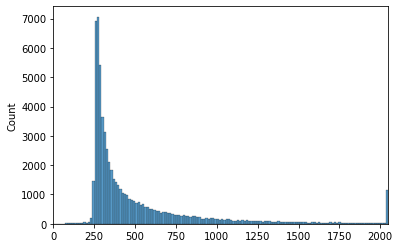

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 2048])

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:


class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.body
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
LABEL_COLUMNS = [data.columns.tolist()[8]]
LABEL_COLUMNS

['Target']

In [ ]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["labels"]

tensor([1.])

In [ ]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=1
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=1
    )

In [ ]:
N_EPOCHS = 7
BATCH_SIZE = 9

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:


class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)

    gc.collect()
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      print(i)
      class_roc_auc = auroc(predictions[:, i], labels[:, i],task="binary")
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
    gc.collect()

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(10096, 50484)

In [ ]:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [ ]:
!kill 3023

In [ ]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

<IPython.core.display.Javascript object>

In [ ]:
gc.collect()

71

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
# trainer = pl.Trainer(
#   logger=logger,
#   checkpoint_callback=checkpoint_callback,
#   callbacks=[early_stopping_callback],
#   max_epochs=N_EPOCHS,
# )

trainer = pl.Trainer(   
    accelerator="gpu",
    auto_lr_find=True,
    auto_scale_batch_size=True,
    fast_dev_run=False,

    logger=logger,   
    callbacks=[early_stopping_callback, checkpoint_callback],   
    max_epochs=N_EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 769   
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.244   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

function ClickConnect(){ console.log("Working"); document.querySelector("colab-toolbar-button#connect").click() } setInterval(ClickConnect,60000)




---


Вот какой результат я получил (но не смог сохранить модель)

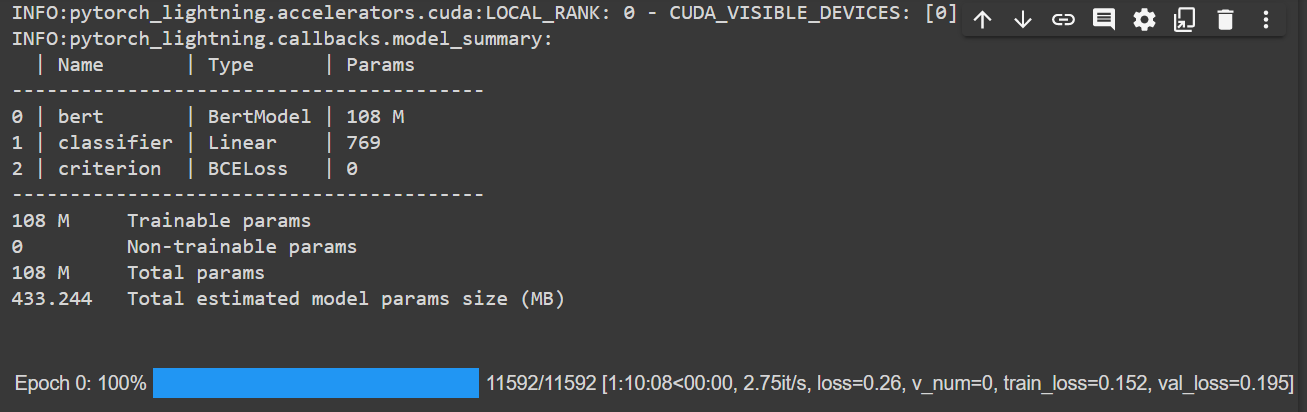

In [ ]:
trainer.test()